In [1]:
import pandas as pd
import joblib
import numpy as np
import pandas as pd
import torch
import os
import torch.optim as optim
import warnings 
warnings.simplefilter('ignore')
from torch.nn import Linear,ReLU,Sigmoid
from utils import *
torch.cuda.is_available()

True

In [2]:
os.listdir('./data')

['train_preprocessed',
 'PA_201605-2020001更新R8(20200423).csv',
 'tag盤點表20200423.xlsx',
 'pred_0997_all.csv',
 'tag盤點表_cleaned.csv',
 'train_cleaned.csv']

# load data,tag,critic,mm_x,mm_y

In [3]:
data = joblib.load('./data/train_preprocessed')

In [4]:
tag = pd.read_csv('./data/tag盤點表_cleaned.csv')
tag_map = dict(zip(tag['TAG'],tag['chinese']))

In [5]:
critic = joblib.load('./model/net.pkl')
critic = critic.eval()
mm_x = joblib.load('./model/mm_x.pkl')
mm_y = joblib.load('./model/mm_y.pkl')

# def columns

In [6]:
x_cols = data['x_col']
y_cols = data['y_col']

In [7]:
x_cols

['MLPAP_FQ-0619.PV',
 'MLPAP_FR-0632.PV',
 'MLPAP_LIC-0738.PV',
 'MLPAP_LRC-0729.PV',
 'MLPAP_PIC-0761.PV',
 'MLPAP_TJ-0757B.PV',
 'MLPAP_TJC-0627.PV',
 'MLPAP_TJC-0757.PV',
 'MLPAP_TJC-0757A.PV',
 'MLPAP_TJC-1721.PV',
 'MLPAP_TRC-0610.PV',
 'MLPAP_TRC-0747.PV',
 'MLPAP_TRC-0762.PV',
 'MLPAP_TRC-1734.PV']

In [8]:
y_cols

['MLPAP_FQI-0997.PV']

# critic forward test

In [9]:
t = critic.time_step
n = critic.num_sensor
t,n

(39, 14)

In [10]:
x = np.random.uniform(0,1,size=(t,n))
x = pd.DataFrame(x,columns=x_cols)
x.head()

,MLPAP_FQ-0619.PV,MLPAP_FR-0632.PV,MLPAP_LIC-0738.PV,MLPAP_LRC-0729.PV,MLPAP_PIC-0761.PV,MLPAP_TJ-0757B.PV,MLPAP_TJC-0627.PV,MLPAP_TJC-0757.PV,MLPAP_TJC-0757A.PV,MLPAP_TJC-1721.PV,MLPAP_TRC-0610.PV,MLPAP_TRC-0747.PV,MLPAP_TRC-0762.PV,MLPAP_TRC-1734.PV
0,0.546433,0.222671,0.002979,0.643496,0.574127,0.620476,0.354570,0.154640,0.356897,0.789619,0.580907,0.774787,0.666498,0.604673
1,0.175875,0.840971,0.849761,0.903715,0.086130,0.767026,0.738661,0.608840,0.709876,0.221184,0.901794,0.469238,0.323175,0.678124
2,0.599204,0.838985,0.242323,0.354629,0.796461,0.629495,0.179766,0.124615,0.348650,0.640147,0.644212,0.655046,0.085681,0.875121
3,0.156698,0.444165,0.701303,0.942584,0.263817,0.863840,0.975195,0.872361,0.731489,0.123307,0.348811,0.096779,0.545323,0.304990
4,0.209113,0.959111,0.920710,0.851539,0.751567,0.125613,0.559794,0.628281,0.937798,0.179680,0.813518,0.315552,0.360455,0.619129


In [11]:
y = critic(torch.tensor(x.values.reshape(-1,t*n)).cuda())
print(y)
y = mm_y.inverse_transform(y.detach().cpu().numpy())
y

tensor([[0.2031]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SigmoidBackward>)


array([[6023.19314704]])

# build Actor input set_point output feed and control_factor

In [12]:
def build_Actor(input_shape,output_shape):
    net = torch.nn.Sequential(
        Linear(input_shape,256),
        ReLU(),
        Linear(256,output_shape),
        Sigmoid()
    )
    return net

In [13]:
def init_weights(m):
  if hasattr(m,'weight'):
    torch.nn.init.xavier_uniform(m.weight)
  if hasattr(m,'bias'):  
    m.bias.data.fill_(0)

In [14]:
net = build_Actor(1,t*n).double().cuda()
net.apply(init_weights)
net

Sequential(
  (0): Linear(in_features=1, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=546, bias=True)
  (3): Sigmoid()
)

# st_iter

In [15]:
st = torch.tensor(np.random.uniform(0,1,size=(5000,1))).cuda()
st_datasets = torch.utils.data.TensorDataset(st)
st_iter = torch.utils.data.DataLoader(st_datasets,batch_size=128)
st_iter

# obj function

In [16]:
def obj_function(x,set_point):
    y = critic(x)
    loss = (set_point - y)**2
    return loss.mean()

# optimizer

In [17]:
optimizer = optim.Adam(net.parameters(),lr=1e-4)

# train

In [18]:
def train(net,st_iter,obj_function,optimizer,num_epochs=100):
    train_history = []
    for epoch in range(num_epochs):
        train_avg_loss = 0
        t = 0
        for st in st_iter:
            st = st[0]
            z = net(st).cuda()
            loss = obj_function(z,st)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_avg_loss += loss.item()
            t += 1
        train_avg_loss /= t
        print("epochs {} loss {:.4f}".format(epoch,train_avg_loss))
        train_history.append(train_avg_loss)
    # plt train loss
    plt.plot(np.array(train_history))
    plt.title('train loss')
    # return trained net
    return net

epochs 0 loss 0.0773
epochs 1 loss 0.0706
epochs 2 loss 0.0646
epochs 3 loss 0.0590
epochs 4 loss 0.0538
epochs 5 loss 0.0490
epochs 6 loss 0.0446
epochs 7 loss 0.0405
epochs 8 loss 0.0368
epochs 9 loss 0.0333
epochs 10 loss 0.0302
epochs 11 loss 0.0273
epochs 12 loss 0.0247
epochs 13 loss 0.0223
epochs 14 loss 0.0202
epochs 15 loss 0.0183
epochs 16 loss 0.0166
epochs 17 loss 0.0150
epochs 18 loss 0.0137
epochs 19 loss 0.0125
epochs 20 loss 0.0114
epochs 21 loss 0.0104
epochs 22 loss 0.0096
epochs 23 loss 0.0088
epochs 24 loss 0.0082
epochs 25 loss 0.0076
epochs 26 loss 0.0070
epochs 27 loss 0.0065
epochs 28 loss 0.0061
epochs 29 loss 0.0057
epochs 30 loss 0.0053
epochs 31 loss 0.0050
epochs 32 loss 0.0047
epochs 33 loss 0.0044
epochs 34 loss 0.0042
epochs 35 loss 0.0040
epochs 36 loss 0.0037
epochs 37 loss 0.0036
epochs 38 loss 0.0034
epochs 39 loss 0.0032
epochs 40 loss 0.0031
epochs 41 loss 0.0029
epochs 42 loss 0.0028
epochs 43 loss 0.0027
epochs 44 loss 0.0025
epochs 45 loss 0.002

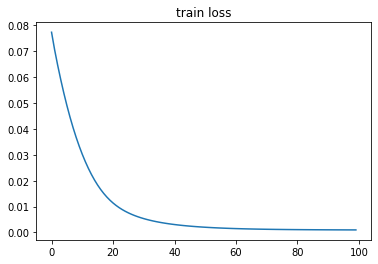

In [19]:
net = train(net,st_iter,obj_function,optimizer,num_epochs=100)

# result

In [20]:
set_point = mm_y.inverse_transform(st.detach().cpu().numpy())
critic_output = mm_y.inverse_transform(critic(net(st)).detach().cpu().numpy())

In [21]:
for i,j in zip(set_point[:10],critic_output[:10]):
    print('user_want:{} critic_output{}'.format(i,j))

user_want:[5173.42037209] critic_output[5535.17819487]
user_want:[5904.15075609] critic_output[5903.54807797]
user_want:[8440.05558053] critic_output[8568.27109945]
user_want:[7186.8408044] critic_output[7085.85694174]
user_want:[5510.44797891] critic_output[5681.59460052]
user_want:[6170.72554014] critic_output[6090.03299116]
user_want:[9301.88906317] critic_output[9292.32739539]
user_want:[5426.59884271] critic_output[5641.72753564]
user_want:[7183.38802998] critic_output[7081.81688674]
user_want:[8533.012109] critic_output[8663.4535934]


# build api

In [22]:
def get_advice(set_point):
    st = mm_y.transform(np.array([[set_point]]))
    st = torch.tensor(st).cuda()
    z = net(st)
    return z

In [23]:
def get_critic_output(advice):
    return mm_y.inverse_transform(critic(advice).detach().cpu().numpy())

# test api

In [32]:
advice = get_advice(8000)

In [33]:
get_critic_output(advice)

array([[8073.30013391]])